<a href="https://colab.research.google.com/github/ghada-ali123/AI_exercise/blob/main/Another_copy_of_week_05_computer_vision_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Chapter 2 - Machine Learning in PyTorch

**This week's exercise has 4 tasks for a total of 6 points (+2 bonus points). Don't forget to submit your solutions to GitHub!**


In this chapter, we want you to become proficient at the following tasks:
- Building a training, validation, and testing script using PyTorch
- Identifying, and being able to build all the typical components of PyTorch model training
- Avoiding, identifying, and fixing typical mistakes in PyTorch model training

#### Chapter 2.5 - PyTorch Modules & Models

Now comes the center piece of training a neural network - the actual neural network.

All we have seen of the neural network so far, is that we stuff a tensor with shape $Batch size * Channels * Height * Width$ into the input, and get a tensor $Batch size * Something$ back out. In our previous example, this something was the number of flower classes. During the course, you have probably been shown what a typical network consists of (things like Convolutional Layers, Fully Connected Layers, Non-Linear Activation Functions, Batch Normalization, etc.), and what these things do, mathematically speaking.

But how do programmers build them? As almost always, the answer is *classes*. Any neural network in PyTorch is a class, which does two things:
- It inherits from a PyTorch class named *torch.nn.Module*.
- It implements an \_\_init\_\_ and a forward method.

The inheritance guarantees that any neural network (and often even its components), follow a common structure. They also guarantee that a lot of useful helper functions, e.g. *model.parameters()*, which lists all weights in a model, are always available to us when we build our own components.

The forward function is implicitly called whenever we stuff something into our model and tell it to make a prediction for us. So, writing `model(data)` or `model.forward(data)` is the same (with very few exceptions). The corresponding backward path, which computes the gradients for each parameter and lets us learn, is mercifully something that PyTorch does *automatically*.

In [9]:
import numpy
import pandas as pd
import PIL
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as ttf

In [10]:
# It's time we built a model ourselves.
# Let's start with a model that does *nothing*.

# We start with a class that inherits from torch.nn.Module.
# We want this to have access to a lot of the useful
# automation features which PyTorch offers.
class Example_Model(torch.nn.Module):


    def __init__(self):
        super(Example_Model, self).__init__()

    # We also want a forward method.

    def forward(self, x):
        return x

# We make an instance of our model, ...
my_first_model = Example_Model()

# ... quickly grab an example "image" to feed in, ...
random_noise = torch.rand((16, 1, 256, 256))

# ... and tell our model to make a forward pass.
# Of course, this prediction is currently bogus.
prediction = my_first_model(random_noise)

print(prediction.size())

torch.Size([16, 1, 256, 256])


In [11]:
# And that's already it!

# ... or is it?
# So far, our model has not done anything, of course, it just spat
# our input tensor back out. Let's give it some learnable parameters.

class Example_Model(torch.nn.Module):

    def __init__(self):
        super(Example_Model, self).__init__()

        # This time, we specify some components.
        # You could write components yourself, but in practice,
        # PyTorch has pretty much all you will ever need.

        # Linear is the name of the fully connected layer in PyTorch,
        # the one you know from MLPs already.
        # The number of in-going signals will be as many as we have
        # pixels in our toy model.
        # The number of out-going features is up to our choosing.
        self.fc1 = torch.nn.Linear(in_features = 1*(256**2), out_features = 3)

        # We will learn more about these components in a little bit.

    def forward(self, x):
        # To turn the image from 2D into "1D" for the fully connected
        # layer, we use the flatten() method.
        # Remember that when we flatten our tensor, we only flatten the image,
        # not the batch dimension, or else we start mixing images together!
        x = x.flatten(start_dim = 1)
        # This time, we actually use our predefined layer in our
        # forward pass.
        x = self.fc1(x)
        return x

my_second_model = Example_Model()
random_noise = torch.rand((16, 1, 256, 256))
prediction = my_second_model(random_noise)
print(prediction.size())

torch.Size([16, 3])


In [12]:
# You can also look at what building blocks your model is composed of:
print(my_second_model)

Example_Model(
  (fc1): Linear(in_features=65536, out_features=3, bias=True)
)


In [13]:
# and what your parameters currently are:
for name, param in my_second_model.named_parameters():
    print(f"{name}: {param}")

fc1.weight: Parameter containing:
tensor([[-2.8508e-03, -3.8779e-03,  3.3022e-03,  ..., -1.8079e-03,
         -1.4796e-03, -2.5105e-03],
        [-2.8217e-04, -2.1826e-03, -9.5981e-04,  ..., -3.2644e-03,
          7.6602e-05,  2.1344e-03],
        [-7.4306e-04,  5.8538e-06,  1.4912e-03,  ...,  1.8811e-04,
          1.0114e-04,  2.9874e-03]], requires_grad=True)
fc1.bias: Parameter containing:
tensor([-0.0021,  0.0014,  0.0021], requires_grad=True)


For those who want to dive deeper:

When we wrote `self.fc1 = nn.Linear(...)`, we added a module to our model (duh), and the class can henceforth refer to this module by its name (e.g. `x = self.fc1(x)` works). The model also knows to collect gradients for and to update the parameters of these modules. If you want to build sophisticated models, sometimes you will not handcraft everything, but rather make a couple of building blocks, and want to add a variable number of them to your model. For such cases, there is a function named `self.add_module(name, child_module)`. In essence, the following two things are equivalent:
- `self.add_module("fc1", nn.Linear(...))`
- `self.fc1 = nn.Linear(...)`

However, sometimes it is very convenient being able to fill in the left side of the equation dynamically.

#### Chapter 2.6 - Model Lego

In the preceding weeks of the seminar, you have probably learnt about some of the concepts behind neural networks. If not, or if you do not remember, here is a little crash course on what building blocks we have, how they work, and how we can easily conceptualize what they do.

There are far more things that PyTorch can do, and it would be quite impossible to showcase all of them here. Others, like BatchNorm, we will learn about as we implement architectures from the more recent neural network milestone papers. If you come across something you haven't heard before in a paper, or have an idea for something you'd like to try, there is a good chance that you can find this operation already fully implemented in PyTorch - try googling it! You will find that the PyTorch documentation is quite good, and that you can discover some very useful features this way.

**Linear layers** - The simplest and oldest component of a neural network is the Linear layer, often called a Fully Connected layer. A fully connected layer is defined by a number of in-going and out-going connections. The number of in-going connections, naturally, is the same as the number of out-going connections from the layer before. The number of out-going connections can be is chosen so that every node in our layer is connected to every node in the following layer.

The Linear layer is called linear because each out-going signal equals the sum of all products of a node's weight and in-going signal, plus a bias term per node:
$y_i = \sum_{j} w_{ij}* x_j + b_i$

This makes it, mathematically speaking, a linear transformation plus a translation (also called an affine transformation):
$y = x*A^T +b$

In [14]:
# In PyTorch, a Linear layer that takes 20 input signals and gives 10 output signals is made like this:

fc1 = torch.nn.Linear(in_features = 20, out_features = 10)

**Activation functions** - Where neural networks are concerned, Linear layers are nice, but come with an inherent problem: Any combination of two affine transformations, is itself an affine transformation. Consequently, neural networks do not really gain much from multiple Linear layers that one Linear layer couldn't have done, and also generally have trouble capturing higher-order polynomial dependencies in data.

However, there is a solution to this problem! A so-called activation function is commonly added after every Linear layer (and typically also after convolutions, which we will get to later), and its purpose is to introduce some form of non-linear transformation between our affine transformations. The combination `Affine + Affine` can be expressed as a single Affine, so it can encode the information of only one Affine Transformation. The combination `Affine + Non-linear function + Affine` cannot be expressed as a single Affine anymore. In this case, having two separate Affine Transformations is suddenly useful, and the issues capturing non-linear and particularly higher-order polynomial dependencies are lessened.

There is a multitude of different activation functions, and historically, different ones have been used for different reasons. The most common among these activation functions are:
- Tangens Hyperbolicus: $tanh(x) = \frac{e^{2x}-1}{e^{2x}+1}$
- Sigmoid: $\sigma(x) = \frac{1}{(1+e^{-x})}$
- ReLU: $R(x) = \{0 $ if $ x<0 $, else $ x\}$
- Swish: $S(x) = \frac{x}{(1+e^{-ßx})}$

All of them have different advantages and disadvantages, although in most modern neural networks, you don't really feel either of them:
- Sigmoid and Tanh are smooth, non-linear functions. In some cases, this affords you smoother outputs with fewer kinks. As a potential downside, the activations saturate for large absolute values (see plot). If our weights are large enough, this can create problems: Suddenly, all our activations look similar, even for very different inputs. This is typically very undesirable, and can cause models to stop learning.
- ReLU has no continuous non-linearity, only a single point (zero) at which the function is not continuous. It is somewhat weaker in capturing non-linear dependencies as a result. However, it has really friendly and smooth gradients, which makes training with ReLU very stable and reliable. If your model ever doesn't learn, it's probably not ReLU's fault.
- Swish is a modern activation function that was found by systematically testing random combinations or chains of functions and observing how they performed as activation functions. It looks very similar to ReLU and approaches ReLU for large absolute values, but has a smooth non-linearity around 0 instead of a kink. Generally, it has the same advantages as ReLU, and is said to have the same downsides except less pronounced. There are many other brands of "ReLU but slightly different" out there. If you're ever looking to squeeze out the final few drops of performance from your model, it can be worth checking them out.

The most important things are this: Firstly, all activation functions have at least one non-linearity, sometimes even a big continuous one, and typically they are near zero. Secondly, most have a region where they function best. Take for example, the sigmoid, which neatly differentiates inputs near zero, but provides almost the same output for inputs that are very large or small. Typically this region is also near zero.

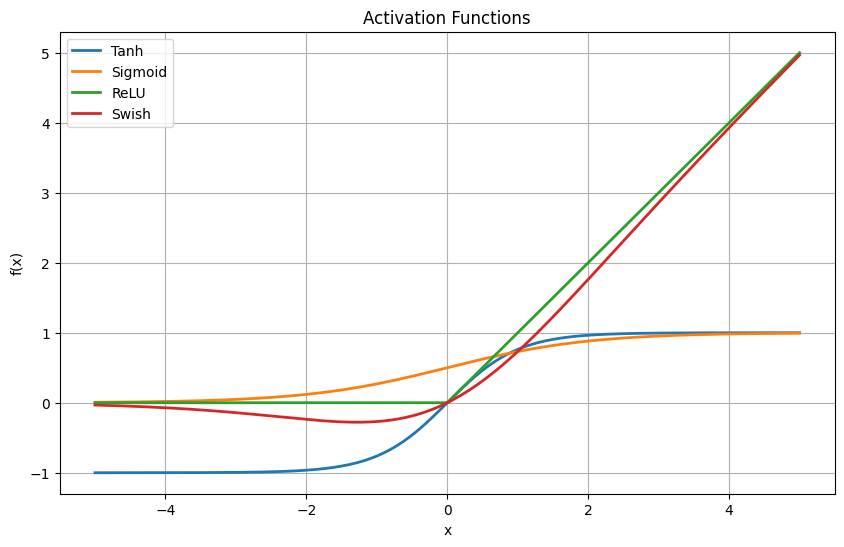

In [15]:
# Here are some plots for the various functions:
import numpy as np
import matplotlib.pyplot as plt

# Define the functions
def tanh(x):
    return np.tanh(x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def swish(x):
    return x * sigmoid(x) # ß = 1

# Create an array of x values
x = np.linspace(-5, 5, 400)

# Calculate y values for each function
y_tanh = tanh(x)
y_sigmoid = sigmoid(x)
y_relu = relu(x)
y_swish = swish(x)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y_tanh, label='Tanh', linewidth=2)
plt.plot(x, y_sigmoid, label='Sigmoid', linewidth=2)
plt.plot(x, y_relu, label='ReLU', linewidth=2)
plt.plot(x, y_swish, label='Swish', linewidth=2)

plt.title('Activation Functions')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# In PyTorch, these functions can be invoked via:

# This is a class instance of the ReLU class
relu = torch.nn.ReLU()

# It does almost nothing except apply the ReLU function to
# your tensor, and being almost everywhere differentiable.
some_tensor = torch.randn((16,3,256,256))
some_tensor = relu(some_tensor)

**Convolution layers** - Conceptually, you can imagine a convolution operation as asking the question 'Where on my image do I have the feature **f**'? The (typical 2D) convolution operator (or kernel) is a tensor of shape M x N. The convolution operation assigns the value of a pixel in the result image by computing the element-wise product of our input image in an area around a so-called *anchor pixel* and the convolution kernel, and then summing. This process is repeated for all pixels in the original image:  
  
$I_{new}[x, y] = (I * K)[x, y] = \sum_{a}\sum_{b} K[a, b]*I[x - a, y - b]$  
  
with $I$ being our original image, $I_{new}$ being the result image, and $K$ being the convolution kernel.
*In layman's terms, if you draw a little circle into the kernel, then the result of convolving the input image is a map of where in the input image you can find circles like the one in the kernel*. It is therefore often called a *feature map* or an *activation map*.

In a modern neural network, convolutional layers are ubiquitous. The computer will, over the course of the training, adapt the contents of the convolution kernels in order to best represent and categorize the images it sees. Features in early convolutional layers correspond to the actual content of the image and make intuitive sense to a human observer - to classify cars, you can expect to be needing a couple of differently angled straight lines, some smooth curves, and circles for the wheels, for example. The features in later layers are less (or not at all) interpretable to human eyes. At that point, the image that the computer has, typically consists of activation maps of activation maps of activation maps of ... well, you get the gist.

It is still possible to visualize what these represent, and some of the features are surprisingly human-interpretable (such as an entire car wheel, or the texture of a brick wall), while others look like LSD-induced hallucinations. If we have some time at the end of the course, we may try our hands at this visualization ourselves, and take a look at how your neural networks see the world.

Convolution operations are defined by their number of in-going and out-going signal channels. At the beginning of a neural network, the in-going channel number is typically 3 (for RGB images) or 1 (for grayscale images). The out-going channel number can be freely chosen. Convolution operations can have any kernel size, but typically its height and width are chosen as odd numbers. This is done because the convolution kernel is applied to the area around the anchor pixel in our original image - a kernel with odd dimensions can be centered exactly on this anchor, while one with even dimensions can not. The latter case causes interesting systematic errors, which are fun to look at, but have a tendency to ruin the performance of the neural network.

In [ ]:
# In PyTorch, Convolutions can be invoked by setting them
# up as an instance of the various classes PyTorch offers:

# This is a class instance of the 2D Convolution class from PyTorch
conv = torch.nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = (3, 3))

# It applies a convolution kernel of size 3x3 across 3 input channels and for 8 output channels
some_tensor = torch.randn((16,3,256,256))
print(some_tensor.size())
some_tensor = conv(some_tensor)
print(some_tensor.size())

**Pooling operations** - Conceptually, a pooling operation is quite simple. We compute a new image from a pooling operation by starting at a pixel, and applying the pooling operator to the pixel and its surroundings. The result is the value of the a new pixel. This process is repeated for every pixel in the image and you get a new image. Typically, the pooling operator either performs the max() or the mean() operation on the area it is applied to. These specific pooling ops are name MaxPool and AvgPool, respectively.

Very often, something called a 'stride' is applied during the pooling operation. 'A stride of *s*' means that in order to get a new image, we do not iterate over every pixel and perform pooling on its respective surrounding, but that we instead skip *s* rows and columns on each step. Typically, stride and pooling operator shapes are chosen to be the same, so that no pixel is ignored during the calculations, and so that no pixel contributes to the new image more than once. Consequently, the new image after a pooling operation will be downscaled by a factor *s*. Since, in a sense, the new image still contains *all, or most of the relevant* information from the original image, strided pooling is often used for exactly this downscaling effect. This reduces the amount of computation needed for later steps, and helps extracting the most relevant information from an image.

If you try to imagine applying a 2x2 pooling operator to, say, a 5x5 image, do you notice a problem? No matter how you define the 2x2 surrounding of your current pixel, some pixels you need to calculate the result of the pooling operator will not exist - they would be outside the bounds of our image! This is a very common occurence, and pooling operations perform something called *padding*. Padding extends the image by the necessary pixels, just for the calculations of pixels that actually exist. Typically, the image is extended using pixels which exclusively have the values zero, although other paddings exist. Convolution operations sometimes do the same thing, for the same reason.

In [17]:
# In PyTorch, these pooling operations can be invoked via:

# This is a class instance of the MaxPool2d class
max_pool = torch.nn.MaxPool2d(kernel_size = (2, 2), stride = 2)

# It does almost nothing except apply the ReLU function to
# your tensor, and being differentiable.
some_tensor = torch.randn((16,3,256,256))
some_tensor = max_pool(some_tensor)

And now it's your turn.

**Task 1 (2 points)**: Try to make a model that performs mathematical operations that you've learned about in the course. For example, try adding in a convolutional layer or two, a fully connected layer or two, and nonlinearities such as ReLUs or tanhs.

Let's prepare ourselves to make a model for the LiTS 2017 classification task that we've already previously talked about. All the model has to do is take the dummy batch below as input (batch size 16, three channels, 256 by 256 pixels), and produce an output of the shape B x 3, for the three classes Nothing, Liver, Liver+Tumor. It doesn't have to be good, or clever, or work particularly well for now. All we want is for you to get a feeling for the various layers we discussed, how to manipulate your input tensors into different shapes, and which input and output shapes a tensor will have after you add a specific layer.

**Task 2 (1 point)**: Where in a convolutional neural network would you use a fully connected layer, if at all, and where shouldn't you? Why?

**Task 3 (1 point)**: Which shape do convolution layer weights have if the input image has more than one input and output channel? To show that you understand the math properly, explain in simple terms why it must have this shape. A visual explanation probably works best. (You can look the shape up in your own code, if you don't know.)

In [ ]:
# using the fully connected layer at the end of CNN. In other words, using fc layer after all convolution and pooling is complete.
# where you shouldnt use it? Anywhere before the convolution/pooling feature extraction is complete
# Why?  1-It destroys the spatial structure too early
#       2-It massively increases parameter counts
#       3-It slows training and reduces generalization

In [18]:
# This dummy batch (batch size 16, 3 channels, 256x256 pixels)
# will be your input. Try to see if the output of your model is
# what you expected it to be.
dummy_batch = torch.rand((16, 3, 256, 256))

# Remember that you can use some_tensor.size() to check the
# current dimensions of your tensor, so that you keep track of
# what the things you've just added do.

In [19]:
class Really_Good_Model(torch.nn.Module):

    """
    Note that this model only has to work for us to count the task as completed.
    You can build any model you like here. We made a tiny CNN.
    """

    def __init__(self):
        super(Really_Good_Model, self).__init__()

        # conv. blocks
        self.conv1 = torch.nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = (3, 3))

        # non linear function (activation function)
        self.relu = torch.nn.ReLU()

        # decrese the image size

        self.pool = torch.nn.MaxPool2d(kernel_size = (3, 3))

        # Calculate the input features for the FC layer dynamically
        # Input: (batch_size, 3, 256, 256)
        # After conv1 (kernel 3, stride 1, padding 0): (batch_size, 8, 254, 254)
        # After pool (kernel 3, stride 3): (batch_size, 8, 84, 84) (floor((254-3)/3) + 1 = 84)
        # Flattened size: 8 * 84 * 84 = 56448
        self.FC = torch.nn.Linear(in_features = 8 * 84* 84, out_features = 3)

    def forward(self, x: torch.Tensor):
         # conv1 and relu
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        # flatten to data to be acceptable in fully connected layer
        x = x.view(x.size(0), -1)
        x = self.FC(x)
        return x

a_really_good_model = Really_Good_Model()
prediction = a_really_good_model(dummy_batch)
# This should yield a 16 x 3 tensor. If it does, you've solved Task 1.
print(prediction.size())

torch.Size([16, 3])


#### Chapter 2.7 - Putting it all together

We have all the pieces. We have a recipe, with which we can train a model using some data. We have made ourselves a dataset, using the LiTS data, last week. And we know how to make our own, small, CNN models.

**Task 4 (2 points + 2 bonus points)**: Stitch together all the individual parts that you have built and classify the LiTS 2017 data into the three classes NOTHING (0), LIVER (1), LIVER+TUMOR (2). You are allowed to just copy your previous solutions. Try using as many of the things you have learnt about as possible, and see if your neural network is capable of training to recognize liver cancer. You script has to do the following things:
- Use your own dataset of LiTS 2017.
- Use your own model from before.
- Train your own model.
- Use your own hyperparameters, if any. If you use hyperparameters or settings we have not discussed before, be ready to explain them to us.

Whichever group gets the best results (you can build some different models and try out hyperparameters of your choosing), **gets 2 bonus points**. :v)

If the loss goes down and your model's predictions are better than random guesses or all-zero guesses, the task is considered solved. All-zero guesses refers to the model always predicting "No Liver, No Tumors", which is typically class number 0 - this is a common failure mode for this task, and would not count. To check whether your solution works, take a look at your model's predictions.

Below are some tips, things that students have had trouble with in the past, what they did and how you can spot whether you're accidentally doing them:
- **Model loss never goes down** - Is your model always trainable, or did you put a model.eval() somewhere and never go back to model?train()? If you forget this, you never track gradients and consequently cannot learn. If the loss is always the same, very specific number, and your model is definitely trainable, it may also be something else. Maybe your model performs a softmax operation on its output, but the loss also does?
- **Training loss immediately goes to zero** - You may be accidentally feeding your model the correct solutions as part of the input. Basically, the model "cheats" but never learns anything.
- **Predictions are all the same class, loss is not going down or not a lot** - Your model is probably capable of learning, because this does not happen randomly, but it's probably not very good at learning. The issue is likely in the model class.

In [2]:
# Download our data again:
!pip install -q gdown
!gdown --id 1TItTaso19GFTPdDnynVnqJvHsCm_RGlI -O Clean_LiTS.zip
!rm -rf ./sample_data/
!unzip -qq Clean_LiTS.zip
!rm ./Clean_LiTS.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1TItTaso19GFTPdDnynVnqJvHsCm_RGlI
From (redirected): https://drive.google.com/uc?id=1TItTaso19GFTPdDnynVnqJvHsCm_RGlI&confirm=t&uuid=c3784132-e58c-4679-8035-af6b3a67876f
To: /content/Clean_LiTS.zip
100% 2.56G/2.56G [01:05<00:00, 39.0MB/s]


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import pandas as pd
import numpy as np
from PIL import Image
import os


                    # DATASET CLASS
# ============================================================
class LiTS_Dataset(Dataset):
    """Reads LiTS CSVs and outputs (image, label) tensors."""
    def __init__(self, train_csv: str, val_csv: str, test_csv: str):
        self.root_dir = "./Clean_LiTS/"

        # Load CSVs and mark split
        train_df = pd.read_csv(os.path.join(self.root_dir, train_csv)).assign(split="train")
        val_df   = pd.read_csv(os.path.join(self.root_dir, val_csv)).assign(split="val")
        test_df  = pd.read_csv(os.path.join(self.root_dir, test_csv)).assign(split="test")

        # Combine all into one DataFrame
        self.data = pd.concat([train_df, val_df, test_df], ignore_index=True)

        self.image_paths = self.data["filename"].tolist()
        self.labels      = self.data["lesion_visible"].tolist()
        self.splits      = self.data["split"].tolist()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        filename = self.image_paths[idx]
        label    = self.labels[idx]
        split    = self.splits[idx]

        img_path = os.path.join(self.root_dir, split, filename)

        # Load image as grayscale
        image = Image.open(img_path).convert("L")
        image_tensor = torch.from_numpy(
            np.array(image, dtype=np.float32) / 255.0
        ).unsqueeze(0)            # (1, H, W)

        label_tensor = torch.tensor(int(label), dtype=torch.long)

        return image_tensor, label_tensor

# ============================================================
#                      CNN MODEL
# ============================================================
class LiTS_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 256→128

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 128→64

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),   # 64→32
        )

        # compute flatten size dynamically
        demo = torch.randn(1, 1, 256, 256)
        with torch.no_grad():
            flat = self.features(demo).view(1, -1).shape[1]

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(flat, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 3)    # Changed from 128 to 32
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x

# ============================================================
#              BUILD DATASETS + DATALOADERS
# ============================================================
full_dataset = LiTS_Dataset("train_classes.csv", "val_classes.csv", "test_classes.csv")

# Split indices
train_indices = [i for i, s in enumerate(full_dataset.splits) if s == "train"]
val_indices   = [i for i, s in enumerate(full_dataset.splits) if s == "val"]
test_indices  = [i for i, s in enumerate(full_dataset.splits) if s == "test"]

train_set = torch.utils.data.Subset(full_dataset, train_indices)
val_set   = torch.utils.data.Subset(full_dataset, val_indices)
test_set  = torch.utils.data.Subset(full_dataset, test_indices)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=16, shuffle=False)

# ============================================================
#                     TRAINING SETUP
# ============================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = LiTS_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

# ============================================================
#                     TRAINING + VALIDATION
# ============================================================
for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total if val_total > 0 else 0.0

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"- Train Loss: {train_loss:.4f} "
          f"- Val Acc: {val_acc:.4f}")

# ============================================================
#                           TESTING
# ============================================================
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print("\n")
print(f"  FINAL TEST ACCURACY: {test_acc:.4f}")


Using device: cuda
Epoch 1/10 - Train Loss: 410.3271 - Val Acc: 0.8447
Epoch 2/10 - Train Loss: 191.2793 - Val Acc: 0.8503
Epoch 3/10 - Train Loss: 128.7630 - Val Acc: 0.8282
Epoch 4/10 - Train Loss: 100.6804 - Val Acc: 0.8592
Epoch 5/10 - Train Loss: 88.3522 - Val Acc: 0.8865
Epoch 6/10 - Train Loss: 75.5996 - Val Acc: 0.8776
Epoch 7/10 - Train Loss: 70.6006 - Val Acc: 0.8766
Epoch 8/10 - Train Loss: 63.9045 - Val Acc: 0.9098
Epoch 9/10 - Train Loss: 58.6313 - Val Acc: 0.8786
Epoch 10/10 - Train Loss: 54.7548 - Val Acc: 0.8674


  FINAL TEST ACCURACY: 0.8489
